# Ordinals Explained
Why does the [ordinal()](api/openskill/models/weng_lin/plackett_luce/index.rst#openskill.models.weng_lin.plackett_luce.PlackettLuceRating.ordinal) function not reflect the ranks passed into [rate()](api/openskill/models/weng_lin/plackett_luce/index.rst#openskill.models.weng_lin.plackett_luce.PlackettLuce.rate)? Consider for instance the example below:

Let's first install some packages we need.

In [12]:
%pip install pandas
%pip install matplotlib
%pip install numpy

# Import openskill.py and plotting libraries.
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
from openskill.models import PlackettLuce

# Initialize Default/Starter Rating
model = PlackettLuce()
r = model.rating

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


Let's start with a simple case of what we know should work. Which is that ranks passed in will reflect the values of ordinals:


In [13]:
# Relevant Code
result = model.rate(teams=[[r()], [r()], [r()], [r()]], ranks=[1, 2, 3, 4])

# DataFrame Code
df = pd.DataFrame([_[0].__dict__ for _ in result])
df["ordinal"] = [_[0].ordinal() for _ in result]
df

,id,name,mu,sigma,ordinal
0,707a027966d74db88261a79a97ac490b,None,27.795253,8.263572,3.004537
1,f810cf4fcd1c42b9a1fdc99652404d08,None,26.552918,8.179618,2.014064
2,06a4432f86e148379d7ab34306ebc61f,None,24.689416,8.084128,0.437033
3,67cae4cfff664caa86405478b42ac634,None,20.962413,8.084128,-3.289971


Let's visualize the distributions of the 4 skills.

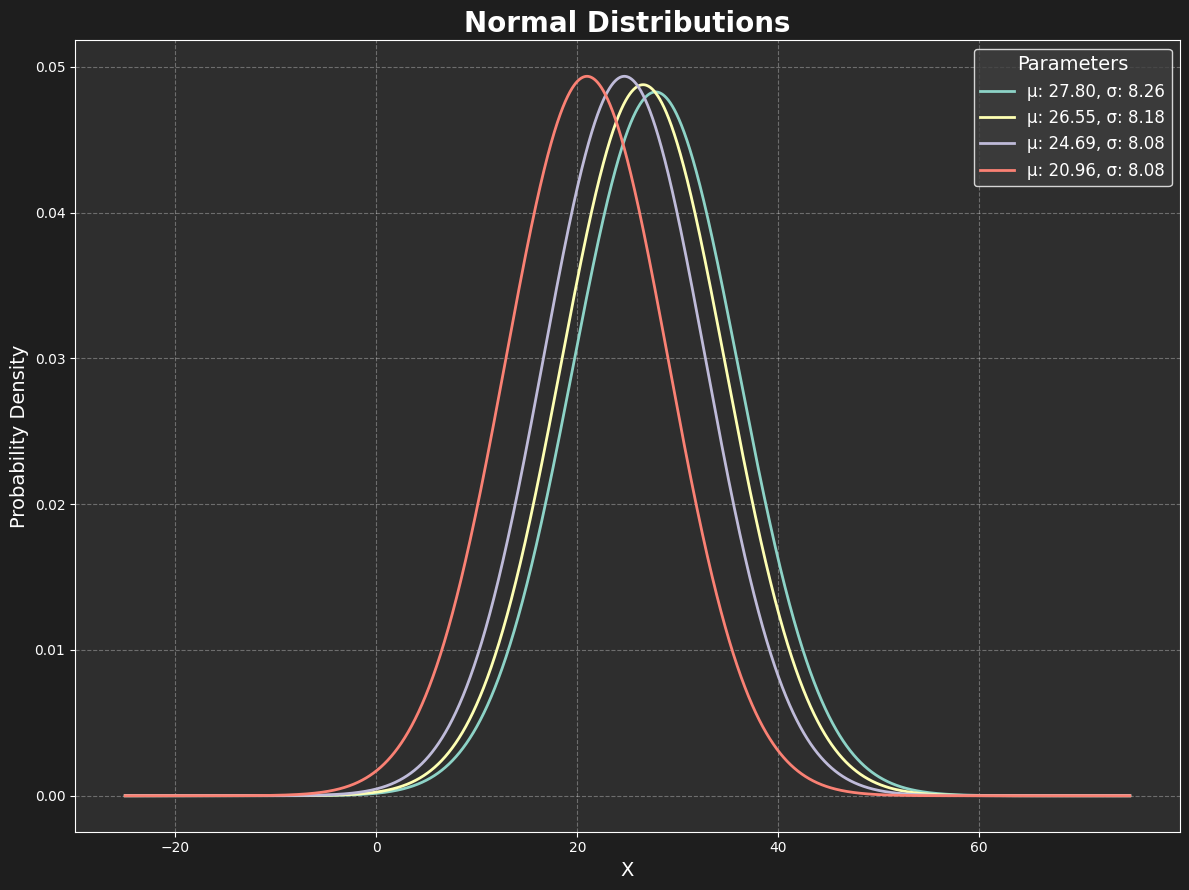

In [14]:
visualization_data = np.arange(-25, 75, 0.001)
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 9), dpi=100)
fig.patch.set_facecolor("#1E1E1E")
ax.set_facecolor("#2E2E2E")

df.apply(
    lambda row: ax.plot(
        visualization_data,
        norm.pdf(visualization_data, row["mu"], row["sigma"]),
        label=f"μ: {row['mu']:.2f}, σ: {row['sigma']:.2f}",
        linewidth=2,
    ),
    axis=1,
)

ax.set_title("Normal Distributions", fontsize=20, color="white", fontweight="bold")
ax.set_xlabel("X", fontsize=14, color="white")
ax.set_ylabel("Probability Density", fontsize=14, color="white")
ax.tick_params(colors="white", which="both")
ax.grid(True, linestyle="--", alpha=0.3)

legend = ax.legend(title="Parameters", title_fontsize=14, fontsize=12)
legend.get_frame().set_facecolor("#3E3E3E")
legend.get_frame().set_edgecolor("white")
plt.setp(legend.get_texts(), color="white")
plt.setp(legend.get_title(), color="white")
plt.tight_layout()
plt.show()

You may have already noticed from the distributions of the system's assesment of playeys skills that the lower ranked players are shifted from to the left from the mean.

Let's try visualizing an edge case. First let's see the ordinals from a tied game with 5 players

In [15]:
# Relevant Code - 5 Players with Ties
result = model.rate(teams=[[r()], [r()], [r()], [r()], [r()]], ranks=[1, 2, 3, 2, 4])

# DataFrame Code
df = pd.DataFrame([_[0].__dict__ for _ in result])
df["ordinal"] = [_[0].ordinal() for _ in result]
df

,id,name,mu,sigma,ordinal
0,9b60dd03cfa94c6d826e403c3a77b2fc,None,27.666827,8.290970,2.793916
1,88ec6d5136cc43d39fe3e54574fa7c24,None,25.166677,8.240555,0.445012
2,46e697fab2884de3b8dcb535036c76e4,None,25.166677,8.172851,0.648125
3,d819d48ca1654c9090685d8ce6a8e228,None,25.166677,8.240555,0.445012
4,035b1b49ca944759be9c33dde325ee95,None,21.833143,8.172851,-2.685409


Unusual! Player at index 2 has a greater ordinal even though the player is lower in rank. Okay, maybe the ditribution plots give more explanation?

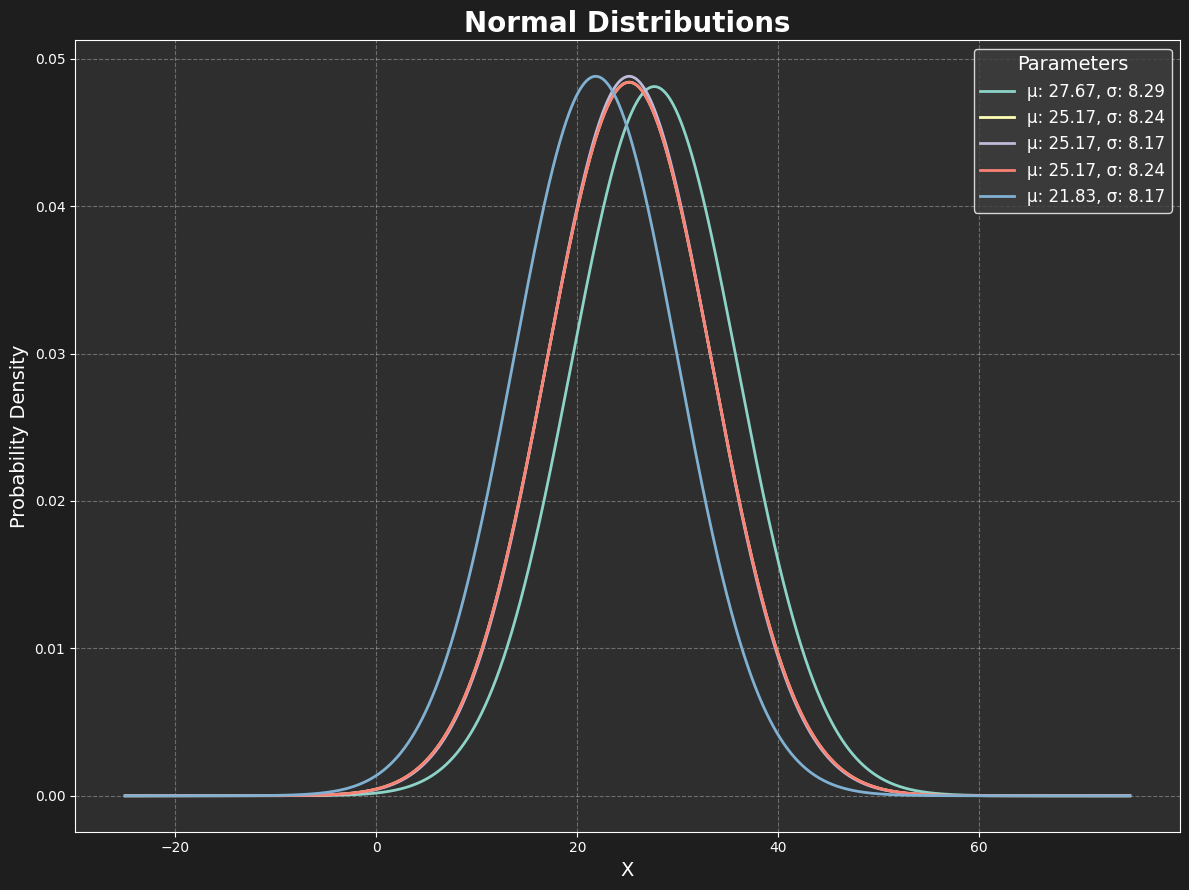

In [16]:
visualization_data = np.arange(-25, 75, 0.001)
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 9), dpi=100)
fig.patch.set_facecolor("#1E1E1E")
ax.set_facecolor("#2E2E2E")

df.apply(
    lambda row: ax.plot(
        visualization_data,
        norm.pdf(visualization_data, row["mu"], row["sigma"]),
        label=f"μ: {row['mu']:.2f}, σ: {row['sigma']:.2f}",
        linewidth=2,
    ),
    axis=1,
)

ax.set_title("Normal Distributions", fontsize=20, color="white", fontweight="bold")
ax.set_xlabel("X", fontsize=14, color="white")
ax.set_ylabel("Probability Density", fontsize=14, color="white")
ax.tick_params(colors="white", which="both")
ax.grid(True, linestyle="--", alpha=0.3)

legend = ax.legend(title="Parameters", title_fontsize=14, fontsize=12)
legend.get_frame().set_facecolor("#3E3E3E")
legend.get_frame().set_edgecolor("white")
plt.setp(legend.get_texts(), color="white")
plt.setp(legend.get_title(), color="white")
plt.tight_layout()
plt.show()

It looks like players at index 1, 2 and 3, they have almost indentical means. So they overlap each other quite a bit. But if you have a keen eye, you will notice that the lavender line representing player at index 2 has a higher peak (also known as negative kurtosis in literature). This means the system is overall more confident in player at index 2's skill.

By default the value of an ordinal is determined by the fomula '$μ - 3σ$' which by the [empirical rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule) only allows for the system to be confident upto 99.7%. As such when $σ$ is still high such as when players have played few games will lead to the overal ordinal fluctuating.

You can curtail this effect for large numbers of matches by using the "Additive Dynamics Factor" $\tau$ (parameter "tau") into the models of this library in combination with the `limit_sigma` parameter.